In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format
import seaborn as sns
sns.set_theme(style='white', palette='crest', font_scale = 1.2, rc={'figure.figsize': (8, 6)})

In [2]:
df_returns = pd.read_excel('gmo_analysis_data.xlsx', sheet_name='returns (total)', parse_dates=True, index_col=0)

In [3]:
df_returns.head()

,GMWAX,SPY
Date,,
1996-11-30,0.0452,0.0730
1996-12-31,-0.0113,-0.0238
1997-01-31,0.0147,0.0618
1997-02-28,0.0223,0.0096
1997-03-31,-0.0152,-0.0441


1. Calculate the mean, volatility, and Sharpe ratio for GMWAX. Do this for three samples:
• from inception through 2011
• 2012-present
• inception - present

In [11]:
metrics = pd.DataFrame(index=df_returns.columns)
metrics['Mean'] = df_returns.mean() * df_returns
metrics['Vol'] = df_returns.std() * np.sqrt(df_returns)
metrics['Sharpe'] = (df_returns.mean() / df_returns.std()) * np.sqrt(annualization)

metrics['Min'] = returns.min()
metrics['Max'] = returns.max()



GMWAX_summary = pd.DataFrame(index=['Inception-2011', '2012-Present', 'Inception-Present'])
adj = 12
GMWAX_summary['annualized_mean'] = np.nanmean(df_returns.GMWAX.iloc[np.where(df_returns.index < '2012-01-01')].GMWAX, axis=0) * adj
GMWAX_summary['annualized_volatility'] = np.nanstd(df_returns.GMWAX.iloc[np.where(df_returns.index >= '2012-01-01')].GMWAX, axis=0) * np.sqrt(adj)

GMWAX_summary['annualized_SR'] = GMWAX_summary['annualized_mean']/GMWAX_summary['annualized_volatility']
display(GMWAX_summary)

AttributeError: 'Series' object has no attribute 'GMWAX'

## 3 Forecast Regression


The active strategies are highly correlated.
The active strategies (in-sample) deliver slightly improved Sharpe Ratio relative to the Passive strategy.
The active strategies (in-sampel) deliver positive alpha and positive Info Ratios
The Earnings-Price signal is more helpful than the Dividend-Price signal, as seen in the EP strategy doing better than the DP strategy.


In [4]:
df_signals = pd.read_excel('gmo_analysis_data.xlsx', sheet_name='signals', parse_dates=True, index_col=0)

df_signals.head()

,DP,EP,US10Y
Date,,,
1996-11-30,2.0100,5.1400,6.0600
1996-12-31,2.0000,5.2100,6.4300
1997-01-31,1.9500,5.1200,6.5300
1997-02-28,1.8800,4.9800,6.5600
1997-03-31,1.9000,5.0800,6.9200


In [5]:
# lag the independent variable, so that we can align date stamps and still have lag
sigs_lag = df_signals.shift().dropna()
# align the data frames to the same subset of dates
sigs_lag, SPY = sigs_lag.align(df_returns.SPY, join="inner", axis=0)

In [6]:
sigs_lag.head()
SPY.head()

Date
1996-12-31   -0.0238
1997-01-31    0.0618
1997-02-28    0.0096
1997-03-31   -0.0441
1997-04-30    0.0626
Name: SPY, dtype: float64

In [7]:
from sklearn.linear_model import LinearRegression

forecasts = df_returns.SPY.expanding().mean().shift(1).dropna()
forecasts.columns = ['Mean']
forecasts.head()

Date
1996-12-31   0.0730
1997-01-31   0.0246
1997-02-28   0.0370
1997-03-31   0.0301
1997-04-30   0.0153
Name: SPY, dtype: float64

In [8]:
# Define the models for the other forecasts
model_map = {'DP':['DP'],'EP':['EP'], 'ALL':df_signals.columns}

for model in model_map.keys():
    X = sigs_lag[model_map[model]]
    forecasts[model] = LinearRegression().fit(X, SPY).predict(X) # lagged signals
    forecasts.dropna(inplace=True)

forecasts.head()

Date
1996-12-31 00:00:00   0.0730
1997-01-31 00:00:00   0.0246
1997-02-28 00:00:00   0.0370
1997-03-31 00:00:00   0.0301
1997-04-30 00:00:00   0.0153
Name: SPY, dtype: object

In [9]:
forecasts = pd.to_numeric(forecasts, errors='coerce')

<AxesSubplot:title={'center':'Forecasts of SPY Returns'}, xlabel='Date'>

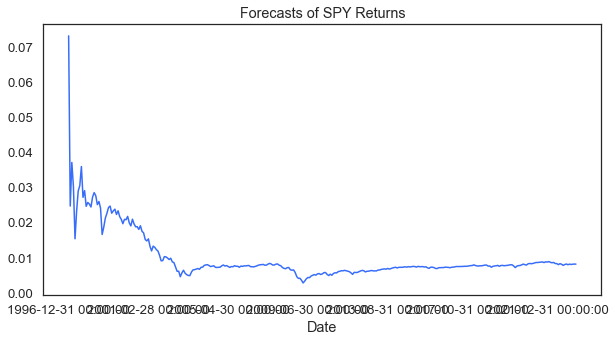

In [10]:
forecasts.plot(figsize=(10,5), title='Forecasts of SPY Returns')

In [11]:
# Define the weights
wts = 100 * forecasts
fund_returns = wts * SPY.values
fund_returns.insert(0, "Passive", SPY)

# Assess the Active Performance
print('Correlation of funds performances:')
fund_returns.corr().style.format("{:.2f}")


ValueError: operands could not be broadcast together with shapes (322,) (319,) 

In [ ]:

def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]

        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y, lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            reg.loc[col, 'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio
        num_roundoff = 1e-12
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

In [ ]:
(fund_returns + 1).cumprod().plot(figsize=(10,5), title='Cumulative Returns of Strategies')

corr_rolling = fund_returns.rolling(50).corr()
dynamic_corrs = corr_rolling['Passive'].unstack(1)
dynamic_corrs = dynamic_corrs.reindex(columns=fund_returns.columns).drop('Passive')
dynamic_corrs.plot(figsize=(10,5), title='Correlation to SPY')
performanceMetrics(fund_returns, annualization=12).style.format("{:.2f}")

tailMetrics(fund_returns).style.format({
    'Skewness':'{:.2f}',
    'Kurtosis':'{:.2f}',
    'VaR (0.05)':'{:.2f}',
    'CVaR (0.05)':'{:.2f}',
    'Max Drawdown':'{:.2f}',
    'Peak':'{%Y-%m}',
    'Bottom':'{%Y-%m}',
    'Recovery':'{%Y-%m}'
})

get_ols_metrics(SPY, fund_returns, annualization=12).style.format({
    'alpha': '{:.2f}',
    'SPY':'{:.2f}',
    'r-squared': '{:.2%}',
    'Treynor Ratio': '{:.2f}',
    'Info Ratio': '{:.2f}',
})

tab2000 = (fund_returns['2000':'2011']+1).cumprod()
tab2000['RF'] = (rf['2000':'2011']+1).cumprod()
tab2000.plot(figsize=(10,5), title="Stock Underperformance?")
